<a href="https://colab.research.google.com/github/Growth-Hackers-SNU/sandbox-youtube-anlaysis/blob/main/code/deeplevel/DunDunDance(%EC%9E%90%EB%AA%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab을 가정하고 쓰여진 코드

## 기본 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm, tqdm_notebook
import pickle 

import matplotlib.pyplot as plt

In [ ]:
! pip install soynlp

     |████████████████████████████████| 419kB 6.7MB/s 


In [ ]:
! pip install kiwipiepy

     |████████████████████████████████| 3.7MB 8.8MB/s 
     |████████████████████████████████| 57.3MB 49kB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.9.0-cp37-none-any.whl size=57496291 sha256=24382a0a7792d495a2cbf062637e00bb99842d66b5ab7976aedc746ae38c2b52
  Stored in directory: /root/.cache/pip/wheels/61/19/a2/f85a7031e0ff829231b4562e6460a84fef599080bbb2573ef7
Successfully built kiwipiepy-model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 사용할 데이터 셋 commentA, commentB, commentC Test Set은 사용하지 않습니다. Validation Set만 하기에도 부족한 걸 
Youtube_comment_label = pd.read_csv("/content/drive/Shareddrives/[GH x Sandbox]/최종분류/sample_final.csv", index_col = 1)
Youtube_comment_label = Youtube_comment_label[['comment', 'class']]
Youtube_comment_label.head()

,comment,class
index,,
1,흠.. 일단 전 안맞을래요,7
2,자식새끼 키워봤자 아무소용업다..,7
3,방테나ㅋㅋㅋ,2
4,하람님 저고민있어욧!!\n노래잘부르고싶은데..어떻게하면 잘 부를수있을까요?오늘도 영...,1
5,희재도 준비하고있고 발표예정이예요\n다시 확인해주세요 모두 준비하고있어요 계약때문에...,7


## 데이터 전처리 및 준비

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# 7번 클래스 -> 0으로 처리 : 나중에 편합니다.
Youtube_comment_label.loc[Youtube_comment_label['class'] ==  7, 'class'] = 0
Youtube_comment_label.head()

,comment,class
index,,
1,흠.. 일단 전 안맞을래요,0
2,자식새끼 키워봤자 아무소용업다..,0
3,방테나ㅋㅋㅋ,2
4,하람님 저고민있어욧!!\n노래잘부르고싶은데..어떻게하면 잘 부를수있을까요?오늘도 영...,1
5,희재도 준비하고있고 발표예정이예요\n다시 확인해주세요 모두 준비하고있어요 계약때문에...,0


In [ ]:
# 각 라벨 갯수가 균형된 데이터 셋, 그냥 raw한 데이터 셋 두 개씩 클래스 3개, 7개 총 4가지 데이터 셋을 만들 겁니다.
Youtube_comment_label3 = Youtube_comment_label.copy()
Youtube_comment_label7 = Youtube_comment_label.copy()
Youtube_comment_label3_balance = Youtube_comment_label.copy()
Youtube_comment_label7_balacne = Youtube_comment_label.copy()

# Youtube_comment_label3
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  1, 'class'] = 1
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  2, 'class'] = 1
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  3, 'class'] = 1
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  4, 'class'] = 2
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  5, 'class'] = 2
Youtube_comment_label3.loc[Youtube_comment_label3['class'] ==  6, 'class'] = 2
Youtube_comment_label3 = Youtube_comment_label3.sort_values(by = 'class', ascending = True).reset_index(drop = True)
print(Youtube_comment_label3.head())
print(f"총 데이터 갯수 : {len(Youtube_comment_label3_balance['comment'])}")
print("-------------------------------------------------------------------------------------------")

# Youtube_comment_label7
Youtube_comment_label7 # 더 건드릴 것이 없다
Youtube_comment_label7 = Youtube_comment_label7_balacne.sort_values(by = 'class', ascending = True).reset_index(drop = True)
print(Youtube_comment_label7.head())
print(f"총 데이터 갯수 : {len(Youtube_comment_label7['comment'])}")
print("-------------------------------------------------------------------------------------------")


# Youtube_comment_label3_balance
Youtube_comment_label3_balance = Youtube_comment_label3.copy()
min_class_num = Youtube_comment_label3_balance.groupby(['class'])['comment'].count().min()
Youtube_comment_label3_balance_df = pd.DataFrame(columns = ['comment', 'class'])
for i in range(3):
  Youtube_comment_label3_balance_df = Youtube_comment_label3_balance_df.append(Youtube_comment_label3_balance.loc[Youtube_comment_label3_balance['class'] == i,
                                                                                                                  ['comment', 'class']].sample(min_class_num))
Youtube_comment_label3_balance = Youtube_comment_label3_balance_df.reset_index(drop = True)
print(Youtube_comment_label3_balance.head())
print(f"각 class 별로 맞춰진 균형 갯수는 : {min_class_num}")
print(f"총 데이터 갯수 : {len(Youtube_comment_label3_balance['comment'])} = 3(class 갯수) * {min_class_num}")
print("-------------------------------------------------------------------------------------------")

# Youtube_comment_label7_balance
Youtube_comment_label7_balance = Youtube_comment_label7.copy()
min_class_num = Youtube_comment_label7_balance.groupby(['class'])['comment'].count().min()
Youtube_comment_label7_balance_df = pd.DataFrame(columns = ['comment', 'class'])
for i in range(7):
  Youtube_comment_label7_balance_df = Youtube_comment_label7_balance_df.append(Youtube_comment_label7_balance.loc[Youtube_comment_label7_balance['class'] == i,
                                                                                                                  ['comment', 'class']].sample(min_class_num))
Youtube_comment_label7_balance = Youtube_comment_label7_balance_df.reset_index(drop = True)
print(Youtube_comment_label7_balance.head())
print(f"각 class 별로 맞춰진 균형 갯수는 : {min_class_num}")
print(f"총 데이터 갯수 : {len(Youtube_comment_label7_balance['comment'])} = 7(class 갯수) * {min_class_num}")
print("-------------------------------------------------------------------------------------------")

                                             comment  class
0                                     흠.. 일단 전 안맞을래요      0
1                                    0:18 KITA 책 ㅋㅋㅋ      0
2  0:55 음 초기에 65세 이상 아스트라 제한한 것도 그러고 이것도 면역력 더 높은...      0
3                                          꼬..꼬끼오..?      0
4                  난 빨랐다를 '발렸다'로 봤네ㅋㅋㅋ잘못보고 정말내내 축구인줄      0
총 데이터 갯수 : 22000
-------------------------------------------------------------------------------------------
                                             comment  class
0                                     흠.. 일단 전 안맞을래요      0
1                                    0:18 KITA 책 ㅋㅋㅋ      0
2  0:55 음 초기에 65세 이상 아스트라 제한한 것도 그러고 이것도 면역력 더 높은...      0
3                                          꼬..꼬끼오..?      0
4                  난 빨랐다를 '발렸다'로 봤네ㅋㅋㅋ잘못보고 정말내내 축구인줄      0
총 데이터 갯수 : 22000
-------------------------------------------------------------------------------------------
                                             comment class
0  

In [ ]:
Youtube_comment_label3_balance.groupby(['class'])['comment'].count()

class
0    2955
1    2955
2    2955
Name: comment, dtype: int64

In [ ]:
Youtube_comment_label3_balance

,comment,class
0,군림보님의 뱃살은 너어어어어어어어어어ㅓㅇ무............(?),0
1,적을 처치할때마다 돌진기 쿨 도는것같아요,0
2,"07:16 혹시 이거 잠뜰 님이 말한 질문에 답 해서 "" 공룡 님보다 거지 같진 않...",0
3,생매장은 한국잊,0
4,수련 로건 석경 석훈,0
...,...,...
8860,와 힘들겠다\n제가 응원할게요,2
8861,그래서 왜 쏜거임?실검없으니깐 불편하다 뭐든지 생각없ㅇ이 하는 나라가 부끄럽다 개...,2
8862,유인씨 깔깔이 같은거 안입으시면 안돼여? ㅋㅋㅋ 깔깔이가 스타일을 죽이고 있어여....,2
8863,저렇게 풀발하고 대응 하는거보니 찔린듯 ㅋㅋ,2


In [ ]:
Youtube_comment_label7

,comment,class
0,흠.. 일단 전 안맞을래요,0
1,0:18 KITA 책 ㅋㅋㅋ,0
2,0:55 음 초기에 65세 이상 아스트라 제한한 것도 그러고 이것도 면역력 더 높은...,0
3,꼬..꼬끼오..?,0
4,난 빨랐다를 '발렸다'로 봤네ㅋㅋㅋ잘못보고 정말내내 축구인줄,0
...,...,...
21995,아이고...맞벌이맘으로써 너무 같이 감정이입이 되어서 맘이 너무 아픈 사건이었네요,6
21996,우리가락 우리소리는 어떻게든 퓨전음악이 된다해도 가슴속에 울림이 있네요..\n듣다보...,6
21997,냥이아빠님.. 슬프지만 괜찮은척하시는 것 같아요... 피츄야 조금만 더 오래 살아줬...,6
21998,6:03 짱구..?ㅎㅎ한국말 진짜 늘었다ㅠㅜ로미야ㅠ,6


In [ ]:
train_data, test_data = train_test_split(Youtube_comment_label7, test_size=1000, random_state=7607)

In [ ]:
X_train = train_data[['comment']]
X_test = test_data[['comment']]
y_train = train_data['class']
y_test = test_data['class']

In [ ]:
X_train

,comment
7959,형!파트코인 해봐!ㄹㅇ 하루에 1cm
2712,끼욱 버려
13606,왕ㅜㅜ 축하드려요💜
18062,0:03ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...
113,""" 콜라를 대신할 소화제 """
...,...
12026,미쵸따미쵸따 어머어머 5월 첫방송이야 ㅠㅠㅠㅠㅠㅠ
17914,깽판친게 아니라 유튜브각을 만들어주네 ㅋㅋ
1355,저거 하실때 폼 꼭 배우세요. 유튜브 찾으면 있어요. 저도 하나 있습니다
12326,보솜이 넘귀엽다 저기 집에서 나가면 바다라니\n저도 정말살고싶은곳이네요


In [ ]:
y_train

7959     0
2712     0
13606    1
18062    2
113      0
        ..
12026    1
17914    2
1355     0
12326    1
7004     0
Name: class, Length: 21000, dtype: int64

## 토큰화
> 자모 토큰화를 진행합니다.

출처: 
https://jins-sw.tistory.com/6

In [ ]:
# 타임 스탬프 삭제
p = re.compile('\d+:\d+')

def delete_time_stamp(df):
    for ix, row in tqdm_notebook(df.iterrows()):
        time_stamp_list = p.findall(str(row['comment']))
        new_comment = str(row['comment'])
        for time_stamp in time_stamp_list:
            new_comment = new_comment.replace(time_stamp, '')
        row['comment'] = new_comment.lstrip()
    return df

In [ ]:
delete_time_stamp(X_train)
delete_time_stamp(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,comment
6067,왜 내가 다 부끄럽냐
18510,이런여자도결혼을하네요
20365,ㅋ방장아 공신력이 없는 인터넷매체애기를 이렇게 애기한다는것은 니가 싸구리라는것을 애...
11461,그만큼 궁금하신거지~
12891,실제로 침형은 삼국지를 많이 모른다 하지만 우리가 더 많이 모른다 오히려 좋아 다 몰라
...,...
2657,채굴용으로 저게 간다면 다행이지 않을까요?
20007,아오 학폭 좀 잠잠해지니까 최갑수씨가 돌아오고 중국이 또 생난리를 치고 방송국들은 ...
9956,솔직히 개를 먹는거는 반대 못하지만 도축 과정에서 고통없이 보냈으면 좋겠다. 개 도...
17310,아 빵딩이 가렸다고 화내는거 개웃기네 ㅋㅋㅋㄱㅋ


In [ ]:
X_train

,comment
7959,형!파트코인 해봐!ㄹㅇ 하루에 1cm
2712,끼욱 버려
13606,왕ㅜㅜ 축하드려요💜
18062,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...
113,""" 콜라를 대신할 소화제 """
...,...
12026,미쵸따미쵸따 어머어머 5월 첫방송이야 ㅠㅠㅠㅠㅠㅠ
17914,깽판친게 아니라 유튜브각을 만들어주네 ㅋㅋ
1355,저거 하실때 폼 꼭 배우세요. 유튜브 찾으면 있어요. 저도 하나 있습니다
12326,보솜이 넘귀엽다 저기 집에서 나가면 바다라니\n저도 정말살고싶은곳이네요


In [ ]:
from kiwipiepy import Kiwi, Option

In [ ]:
from soynlp.hangle import compose, decompose, character_is_korean 
doublespace_pattern = re.compile('\s+') 

def jamo_sentence(sent): 
    def transform(char): 
        if char == ' ': 
            return char 
        cjj = decompose(char) 
        if len(cjj) == 1: 
            return cjj 
        cjj_ = ''.join(c if c != ' ' else '_' for c in cjj) 
        return cjj_ 
    
    sent_ = [] 
    for char in sent: 
        if character_is_korean(char): 
            sent_.append(transform(char)) 
        else: 
            sent_.append(char) 
    sent_ = doublespace_pattern.sub(' ', ''.join(sent_)) 
    return sent_ 
        
def jamo_to_word(jamo): 
    jamo_list, idx = [], 0 
    while idx < len(jamo): 
        if not character_is_korean(jamo[idx]): 
            jamo_list.append(jamo[idx]) 
            idx += 1 
        else: 
            jamo_list.append(jamo[idx:idx + 3]) 
            idx += 3 
            
    word = "" 
    for jamo_char in jamo_list: 
        if len(jamo_char) == 1: 
            word += jamo_char 
        elif jamo_char[2] == "_": 
            word += compose(jamo_char[0], jamo_char[1], " ") 
        else: 
            word += compose(jamo_char[0], jamo_char[1], jamo_char[2]) 
            
    return word

# 출처: https://joyhong.tistory.com/137 [옳은 길로..]

In [ ]:
X_train = X_train.apply(lambda row : jamo_sentence(str(row['comment'])).strip().split(" "), axis=1)
X_test = X_test.apply(lambda row : jamo_sentence(str(row['comment'])).strip().split(" "), axis=1)

In [ ]:
X_train.head(10)

7959     [ㅎㅕㅇ!ㅍㅏ_ㅌㅡ_ㅋㅗ_ㅇㅣㄴ, ㅎㅐ_ㅂㅘ_!ㄹ__ㅇ__, ㅎㅏ_ㄹㅜ_ㅇㅔ_, 1cm]
2712                                      [ㄲㅣ_ㅇㅜㄱ, ㅂㅓ_ㄹㅕ_]
13606                        [ㅇㅘㅇ_ㅜ__ㅜ_, ㅊㅜㄱㅎㅏ_ㄷㅡ_ㄹㅕ_ㅇㅛ_💜]
18062    [ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__...
113                [", ㅋㅗㄹㄹㅏ_ㄹㅡㄹ, ㄷㅐ_ㅅㅣㄴㅎㅏㄹ, ㅅㅗ_ㅎㅘ_ㅈㅔ_, "]
10226              [ㅈㅗ_ㅎㅘ_ㅅㅜ_ㄴㅡㄴ, ㅇㅣㄹㄱㅐ_ㅇㅠ_ㅌㅠ_ㅂㅓ_ㄱㅣㄴ, ㅎㅏㅁ]
3676             [ㅁㅓㅅㄷㅗ_ㅁㅗ_ㄹㅡ_ㄱㅗ_, ㅅㅣㄴㄴㅏㄹ, ㄴㅏ_ㅇㅣ_, ㅋ__ㅋ__]
4663                                             [ㅇㅣㄱㅅㅜ_?]
10882    [ㅎㅓㄹ, ㄱㅜ_ㄱㅡㄹosㄹㅏ_ㄴㅣ_, ㅇㅝ_ㅊㅣ_3, ㅇㅏㄴ, ㅅㅏ_ㄱㅣㄹ, ㅈㅏ...
17947                      [ㅁㅏ_ㅈㅣ_ㅁㅏㄱ, ㅁㅝ_ㄴㅑ_ㄱㅗㅋㅋ__ㅋ__ㅋ__]
dtype: object

## 임베딩
> 이제 임베딩을 해봅시다
> 임베딩은 크게 3가지가 있었습니다.
1. 모델을 세울때 임베딩 층을 넣는 것(이때는 주로 freeze 하지 않고 임베딩도 학습하게 합니다)
2. gensim 의 Word2Vec, FastText 등 을 사용해서 pre-trained 시키고 그거 사용하기
3. 온라인 상의 pre-trained 가져와서 하기.

### 2. FastText로 pre-trained 시키고 이를 사용해서 embedding

출처: https://joyhong.tistory.com/137

#### Merge Whole Data

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
data_DIR = "/content/drive/Shareddrives/[GH x Sandbox]/train/"
file_name_num = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,23,25,51]

files = [f for f in listdir(data_DIR) if isfile(join(data_DIR, f))]
video_stats = [f for f in files if '.csv' in f and 'video' in f]
files = [f for f in files if '.csv' in f and 'comments' in f]
print(files)

df_dict = dict()
for file_name in tqdm(files):
    comment_name = file_name.split('.')[0]
    df = pd.read_csv(data_DIR + file_name, lineterminator='\n')

    df_dict[comment_name] = df

['comments_6.csv', 'comments_4.csv', 'comments_5.csv', 'comments_11.csv', 'comments_7.csv', 'comments_9.csv', 'comments_10.csv', 'comments_12.csv', 'comments_13.csv', 'comments_14.csv', 'comments_16.csv', 'comments_15.csv', 'comments_17.csv', 'comments_18.csv', 'comments_19.csv', 'comments_20.csv', 'comments_21.csv', 'comments_23.csv', 'comments_25.csv', 'comments_51.csv']


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


In [ ]:
whole_df = pd.DataFrame(columns=df_dict['comments_4'].columns)

for category, df in df_dict.items():
    df['category_id'] = int(category.split('_')[1])
    whole_df = pd.concat([whole_df, df], ignore_index=True)

whole_df.tail(10)

,ch_id,ch_title,vid_id,vid_title,comment,likes,reply,published_at,author,category_id
1136000,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),그만큼 옵치가 ㅈ같다는거지~,1,0,2021-03-15T07:05:17Z,UC-hv6fiWQICYeWTIS2NDY2A,51.0
1136001,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),재원님은겐지잘못함,0,0,2021-03-15T08:14:22Z,UCji---Vne7SzpzvS47UI3gA,51.0
1136002,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),옵치 요즘 누가하냐 그 망겜,0,0,2021-03-15T11:08:20Z,UC113nO4yxrgEn1dZ2uTIJDA,51.0
1136003,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),그만큼~그만큼하다는 거지~,2,0,2021-03-15T07:01:54Z,UC9ic-Qk9G5xwYGt3-C2QEzw,51.0
1136004,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),무가 산에가서 하는말은?!?!?!?!?!?\n\n\n\n\n\n무는 말을 못합니다 ...,1,1,2021-03-15T07:03:36Z,UCLeHgPUSrnGE2Doa2q_1Ucg,51.0
1136005,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),김재원 나보다 겐지 못하네,0,0,2021-03-15T07:36:41Z,UC5VPuBYusc_OSmsHsmqx7XQ,51.0
1136006,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),자세히 보기를 누르지마세요\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,0,0,2021-03-15T07:22:09Z,UCDsaz5jOHrveeAbiv3swOAw,51.0
1136007,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),나구독하면 여친생김,1,1,2021-03-15T07:02:26Z,UC5hkMEIYcO7iLrn1A1XLm-g,51.0
1136008,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),재원님 항상 재미있는 영상 만들어 주세요,2,0,2021-03-15T07:01:15Z,UCaaGJ1KOTbvOH4nh-PCzCEA,51.0
1136009,UCta_NRwnsUaew0t3VNxBNyg,김재원의 즐거운 세상,vZrDo5p6uQk,오버워치에서 재연된 무야호 (즐겜워치 33),재원 님 이제 유튜브 그만하시고 접어 보는게 좋을 거 같아요,1,1,2021-03-16T08:09:53Z,UCei5go7g5HpvJIAWhl7MQWg,51.0


In [ ]:
len(whole_df)

1136010

#### Fast Text Modeling

In [ ]:
from gensim.models import FastText

In [ ]:
whole_df['comment'][4]

'5:31 이러다가 서명호 나중에 캐럿들은 정말 유난스러운 존재에요 이러면 어떡함'

In [ ]:
whole_comment_df = whole_df[['comment']]
whole_comment_df = delete_time_stamp(whole_comment_df)
whole_comment_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,comment
0,아니 정한이 숙소 창문에 x자 대문짝만하게 테이프 붙여놓은거 K 아이돌 - 창문이라...
1,아니 심지어 그 방 윤정한방 창문이 아니라 이지훈방 창문아님 ? ㅋㄲㅋㄱㅋㄱㅋㅋㅋㄱ...
2,이거이거 조사를 열심히 하신건지 이거 캐럿아니면 이렇게 할 수가 없는데..?애들 선...
3,민규랑 정한이 비주얼합 좋은거 알고있었지만 이렇게 보니까 진짜최고네ㅠㅠㅠㅠㅠ 원우랑...
4,이러다가 서명호 나중에 캐럿들은 정말 유난스러운 존재에요 이러면 어떡함
5,김민규가 살아 움직인다는것에 감사함을 느낌... 민규야ㅠㅠㅠ
6,너무 웃어서 광대가 아프다...ㅋㅋㅋㄲㅋㅋㅋㅋㅋ뭔가 저 조합 은은하게 웃겨서 더 재...
7,다들 느꼈구나... 이 영상에서 찐한 캐럿의 향기가 나는걸...ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...
8,"캐럿들💎 줌터뷰뿐만 아니라 입틀막하게 만드는 디지털 필름 영상도 남았으니 ,, 세븐..."
9,디에잇 섹시해. 나 미쳐 어쩜좋아. \n명호 머리 깐거 진짜 진리다.


In [ ]:
corpus = whole_comment_df.apply(lambda row : jamo_sentence(str(row['comment'])), axis=1)
corpus = [sent.strip().split(" ") for sent in corpus]
corpus[:10]

[['ㅇㅏ_ㄴㅣ_',
  'ㅈㅓㅇㅎㅏㄴㅇㅣ_',
  'ㅅㅜㄱㅅㅗ_',
  'ㅊㅏㅇㅁㅜㄴㅇㅔ_',
  'xㅈㅏ_',
  'ㄷㅐ_ㅁㅜㄴㅉㅏㄱㅁㅏㄴㅎㅏ_ㄱㅔ_',
  'ㅌㅔ_ㅇㅣ_ㅍㅡ_',
  'ㅂㅜㅌㅇㅕ_ㄴㅗㅎㅇㅡㄴㄱㅓ_',
  'K',
  'ㅇㅏ_ㅇㅣ_ㄷㅗㄹ',
  '-',
  'ㅊㅏㅇㅁㅜㄴㅇㅣ_ㄹㅏ_ㄱㅗ_',
  'ㅇㅣㄴㅌㅓ_ㄴㅔㅅㅇㅔ_',
  'ㄷㅗ_ㄴㅡㄴㄱㅓ_',
  'ㅂㅗ_ㄱㅗ_',
  'ㅃㅏㅇㅌㅓ_ㅈㅣㅁ',
  'ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__'],
 ['ㅇㅏ_ㄴㅣ_',
  'ㅅㅣㅁㅈㅣ_ㅇㅓ_',
  'ㄱㅡ_',
  'ㅂㅏㅇ',
  'ㅇㅠㄴㅈㅓㅇㅎㅏㄴㅂㅏㅇ',
  'ㅊㅏㅇㅁㅜㄴㅇㅣ_',
  'ㅇㅏ_ㄴㅣ_ㄹㅏ_',
  'ㅇㅣ_ㅈㅣ_ㅎㅜㄴㅂㅏㅇ',
  'ㅊㅏㅇㅁㅜㄴㅇㅏ_ㄴㅣㅁ',
  '?',
  'ㅋ__ㄲ__ㅋ__ㄱ__ㅋ__ㄱ__ㅋ__ㅋ__ㅋ__ㄱ__ㅋ__ㄱ__ㅋ__ㄱ__ㅋ__ㄱ__'],
 ['ㅇㅣ_ㄱㅓ_ㅇㅣ_ㄱㅓ_',
  'ㅈㅗ_ㅅㅏ_ㄹㅡㄹ',
  'ㅇㅕㄹㅅㅣㅁㅎㅣ_',
  'ㅎㅏ_ㅅㅣㄴㄱㅓㄴㅈㅣ_',
  'ㅇㅣ_ㄱㅓ_',
  'ㅋㅐ_ㄹㅓㅅㅇㅏ_ㄴㅣ_ㅁㅕㄴ',
  'ㅇㅣ_ㄹㅓㅎㄱㅔ_',
  'ㅎㅏㄹ',
  'ㅅㅜ_ㄱㅏ_',
  'ㅇㅓㅄㄴㅡㄴㄷㅔ_..?ㅇㅐ_ㄷㅡㄹ',
  'ㅅㅓㄴㅁㅜㄹㄷㅗ_',
  'ㅇㅘㄴㅈㅓㄴ',
  'ㅁㅏㅈㅊㅜㅁㅇㅣ_ㄱㅗ_',
  'ㅁㅣㄴㄱㅠ_',
  'ㅇㅕ_ㄱㅣ_ㅅㅓ_ㄷㅗ_',
  'ㅍㅕㄴㅈㅣㅂㅈㅓㅁㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__',
  'ㅋ__ㅇㅜ_ㄹㅣ_',
  'ㅇㅐ_ㄷㅡㄹ',
  'ㅇㅣ_ㅃㅡ_ㄱㅔ_',
  'ㅉㅣㄱㅇㅓ_ㅈㅜ_ㅅㅣ_ㄱㅗ_',
  'ㅇㅣㄴㅌㅓ_ㅂㅠ_',
  'ㅎㅐ_ㅈㅜ_ㅅㅕ_ㅅㅓ_',
  'ㄱㅏㅁㅅㅏ_ㅎㅐ_ㅇㅛㅇ',
  'ㅋㅗ_ㅅㅡ_ㅁㅗ_ㅍㅗㄹㄹㅣ_ㅌㅏㄴ',
  'ㅊㅚ_ㄱㅗ_❣️'],
 ['ㅁㅣㄴㄱㅠ_ㄹㅏㅇ',
  'ㅈㅓㅇㅎㅏㄴㅇㅣ_',
  'ㅂㅣ_ㅈㅜ_ㅇㅓㄹㅎㅏㅂ',
  'ㅈㅗㅎㅇㅡㄴㄱㅓ_',
  'ㅇ

In [ ]:
model = FastText(size=100, window=3, min_count=3, workers=4, sg=1)
model.build_vocab(sentences=corpus)
model.train(
    sentences=corpus, epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words,
)

In [ ]:
# save model
model_fDIR = "/content/drive/MyDrive/GH/SandBoxProject/210524_DL/"
model.save(model_fDIR + 'fasttext')
model.wv.save_word2vec_format(model_fDIR + 'fasttext_vis')

In [ ]:
print(model.wv)

In [ ]:
model.wv.vectors.shape

(283367, 100)

#### embedding 성능 test

In [ ]:
def transform(list_): 
    return [(jamo_to_word(w), r) for (w, r) in list_]


In [ ]:
print(transform(model.wv.most_similar(jamo_sentence('손흥민'), topn=5)))

[('“손흥민', 0.992994487285614), ("'손흥민", 0.992006778717041), ('"손흥민', 0.9919321537017822), ('손흥민?', 0.9894469976425171), ('손흥민.', 0.9882667660713196)]


In [ ]:
print(transform(model.wv.most_similar(jamo_sentence('재미'), topn=5)))

[('재미쒀', 0.9453452229499817), ('재미씀', 0.9396107196807861), ('재미따', 0.9187890887260437), ('재미써', 0.9178105592727661), ('재미져', 0.9103113412857056)]


In [ ]:
print(transform(model.wv.most_similar(jamo_sentence('슬픔'), topn=5)))

[('슬픔,', 0.9623531103134155), ('슬픔..', 0.9216196537017822), ('슬플', 0.9023023843765259), ('슬프단', 0.8952683210372925), ('슬프당..', 0.8917639851570129)]


In [ ]:
print(transform(model.wv.most_similar(jamo_sentence('주단태'), topn=5)))

[('주단태-', 0.9942590594291687), ('주단태~', 0.9901915192604065), ('주단탠', 0.9890368580818176), ('주단탱-', 0.9884690642356873), ('주단탱,', 0.985360860824585)]


In [ ]:
print(transform(model.wv.most_similar(jamo_sentence('무리뉴'), topn=5)))

[('무리뉴:', 0.99093097448349), ('무리뉴~', 0.9878108501434326), ('■무리뉴', 0.9823281168937683), ('“무리뉴', 0.9820902943611145), ("'무리뉴", 0.9820272922515869)]


In [ ]:
model.wv.n_similarity([jamo_sentence("손흥민")], [jamo_sentence("무리뉴")])

0.6619248

In [ ]:
model.wv.n_similarity([jamo_sentence("손흥민")], [jamo_sentence("주단태")])

0.3717371

In [ ]:
model.wv.n_similarity([jamo_sentence("손흥민")], [jamo_sentence("먹방")])

0.16442917

In [ ]:
model.wv.n_similarity([jamo_sentence("손흥민")], [jamo_sentence("축구")])

0.53428406

In [ ]:
model.wv.n_similarity([jamo_sentence("머니게임")], [jamo_sentence("최애")])

0.27210534

In [ ]:
model.wv.n_similarity([jamo_sentence("머니게임")], [jamo_sentence("진용진")])

0.46752903

In [ ]:
model.wv.n_similarity([jamo_sentence("머니게임")], [jamo_sentence("공혁준")])

0.48653892

In [ ]:
model.wv.n_similarity([jamo_sentence("산범")], [jamo_sentence("공혁준")])

0.7007195

In [ ]:
model.wv.n_similarity([jamo_sentence("무리뉴")], [jamo_sentence("공혁준")])

0.46512252

In [ ]:
model.wv.n_similarity([jamo_sentence("트로트")], [jamo_sentence("공혁준")])

0.20399697

#### embedding 된 vector 확인

출처: https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html

In [ ]:
model.wv[jamo_sentence("손흥민")]

array([ 0.57643384, -1.6414546 , -0.24552028, -0.7539332 ,  0.26678166,
        0.35393393, -0.6679476 , -0.6489672 , -0.45171592,  1.4473842 ,
       -0.7428063 , -0.91519433, -0.18956031, -0.34081066, -0.20836973,
        0.56054896, -0.6017387 ,  0.5482094 ,  1.9174218 , -0.9578388 ,
       -0.3180518 , -0.80016017, -1.1227124 ,  0.5960045 ,  0.5047069 ,
        0.628457  , -0.10020398, -2.264909  ,  0.42326355, -0.15910032,
        1.271285  ,  0.55241126,  0.09666578, -0.14403383, -1.6420062 ,
       -0.1275214 , -0.9844335 ,  0.862227  , -0.15074115,  0.49015576,
       -0.16454384,  0.51263183, -0.25504604,  0.23586483,  0.3706472 ,
        1.1367676 , -0.6912528 , -1.1284872 , -0.5130195 ,  0.57426614,
       -0.2588535 , -0.788596  , -1.5116447 ,  0.4324854 ,  1.0688583 ,
       -0.38725674, -0.57333475, -1.1115502 ,  0.27542108, -0.2430949 ,
        0.9331736 , -0.23279065, -0.5711133 , -0.06201376,  0.9205951 ,
       -0.99871296, -0.8155388 ,  0.71681225,  0.82432145, -1.85

In [ ]:
model.wv[jamo_sentence("무리뉴")]

array([ 0.50575805, -0.76800334,  0.07831834, -0.5791681 ,  0.08383565,
       -0.19101423, -0.6039074 , -0.5175718 , -0.32549435,  1.089218  ,
       -0.07534763, -0.6464316 ,  0.90763557, -0.3388166 ,  0.07145465,
        0.4129103 , -1.2022424 ,  0.9761676 ,  0.72677225,  0.07222657,
       -0.6708291 , -0.08267989, -0.50139266, -0.21877243,  1.0338358 ,
       -0.20215616,  0.19997585, -0.8877196 ,  1.0351778 , -0.581828  ,
        1.082519  , -0.00622828,  0.27039063, -0.43332633, -0.25265127,
       -0.46708018, -0.04878039,  0.67188054,  0.49335584,  0.7747082 ,
        0.1857629 ,  0.8365447 , -0.58299357, -0.48687133,  0.38403544,
        1.1583533 , -0.26721588, -0.12822069, -0.66785127,  0.40065596,
       -0.43852365,  0.40031043, -0.31475472, -0.17877993,  0.97563565,
       -0.06083592, -0.35537547, -0.9579187 , -0.18720272, -0.6509618 ,
        1.2590991 ,  0.21215816,  0.37022042,  0.14629762,  0.71335566,
       -0.78622144, -0.51695114,  0.27750993, -0.11644801, -1.12

In [ ]:
model.wv[jamo_sentence("의")]

array([ 1.4210777 , -0.81371677, -0.03749328,  1.1420807 ,  1.3048111 ,
       -2.1337779 ,  0.48601452,  1.6949412 , -1.8845116 ,  0.2717323 ,
       -0.5499069 , -0.10699414, -0.21678694, -0.23970495, -1.7765076 ,
       -0.7156523 ,  1.3386067 ,  1.9705166 , -0.41027206,  1.6301857 ,
        1.4153467 ,  0.25995895, -2.9717543 ,  0.00916565,  1.8039497 ,
        1.9130538 , -2.2541816 ,  2.2106493 ,  1.8905944 ,  1.9232124 ,
       -0.43900123, -0.40546915, -0.12867054,  0.8294946 , -0.7779432 ,
       -3.1666255 , -0.4517913 , -0.02292189, -0.33861905,  0.8084839 ,
        2.359629  ,  2.15161   , -2.1715438 , -0.89377385, -0.18682726,
        0.6211433 , -2.900708  ,  1.17369   , -1.8680288 , -0.05298661,
        2.321277  ,  0.9144438 ,  0.32484016, -0.27662602,  1.0084343 ,
        0.49707267,  0.9757298 ,  0.2192508 , -0.30422705, -1.0776116 ,
        0.23088615, -0.43616104,  1.2460271 ,  1.5946913 ,  1.2349356 ,
        2.286337  , -0.5992277 ,  0.12026838,  0.25284907, -2.48

In [ ]:
model.wv[jamo_sentence("사랑")]

array([-0.6993194 , -0.6766508 ,  1.0852938 ,  1.4949514 ,  0.24718733,
       -0.19989447, -1.083013  ,  1.5152607 ,  0.0308862 ,  1.5063288 ,
        2.6923752 , -1.0928504 , -0.40414062,  0.7002441 ,  1.7981144 ,
       -0.6643979 , -0.2528179 , -0.85075057,  3.4187324 , -0.21016872,
       -1.0372633 ,  0.0653699 , -1.1205925 ,  0.48261562, -0.59057456,
       -2.7071092 ,  1.2039386 ,  0.08677571, -0.22625491, -1.4512116 ,
       -1.9846793 , -0.9723848 ,  0.3016936 ,  0.8163773 ,  0.8181408 ,
        0.03225449,  0.5289174 , -0.31768593, -0.19539957, -0.42638075,
       -0.33651716, -0.52423906, -0.17983942, -0.03452187, -0.87619895,
       -0.14652275, -1.5226325 ,  0.06480377,  0.57030976, -0.257104  ,
        1.694818  ,  1.1884979 , -1.8981036 , -1.1742886 ,  2.2253165 ,
       -0.85738844, -0.4097028 , -0.2864902 ,  0.80733097,  0.18326712,
        0.3484178 , -0.5570772 , -0.5772124 , -0.40836114,  1.1699841 ,
       -0.9056703 ,  0.7106095 ,  0.18948205,  0.29488817, -0.55

#### Embedding 층 학습시키기

##### Preprocess for model input

In [ ]:
from gensim.models import KeyedVectors, FastText

In [ ]:
model_fname = "/content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/fasttext/jamo_fasttext"
embedding_model = FastText.load(model_fname)

In [ ]:
embedding_model.wv.vectors.shape

(283367, 100)

In [ ]:
embedding_matrix = np.zeros((embedding_model.wv.vectors.shape[0]+1, embedding_model.wv.vectors.shape[1]))
np.shape(embedding_matrix)

(283368, 100)

In [ ]:
vocab_size = np.shape(embedding_matrix)[0]
vocab_size

283368

##### FastText의 embeding vector 확인작업 

In [ ]:
embedding_model.wv.vocab

{'ㅇㅏ_ㄴㅣ_': <gensim.models.keyedvectors.Vocab at 0x7f1314e2dcd0>,
 'ㅈㅓㅇㅎㅏㄴㅇㅣ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739a10>,
 'ㅅㅜㄱㅅㅗ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739bd0>,
 'ㅊㅏㅇㅁㅜㄴㅇㅔ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739fd0>,
 'ㄷㅐ_ㅁㅜㄴㅉㅏㄱㅁㅏㄴㅎㅏ_ㄱㅔ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739c90>,
 'ㅌㅔ_ㅇㅣ_ㅍㅡ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739710>,
 'K': <gensim.models.keyedvectors.Vocab at 0x7f1315739b90>,
 'ㅇㅏ_ㅇㅣ_ㄷㅗㄹ': <gensim.models.keyedvectors.Vocab at 0x7f1315739f90>,
 '-': <gensim.models.keyedvectors.Vocab at 0x7f1315739f10>,
 'ㅇㅣㄴㅌㅓ_ㄴㅔㅅㅇㅔ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739490>,
 'ㄷㅗ_ㄴㅡㄴㄱㅓ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739310>,
 'ㅂㅗ_ㄱㅗ_': <gensim.models.keyedvectors.Vocab at 0x7f1315739450>,
 'ㅃㅏㅇㅌㅓ_ㅈㅣㅁ': <gensim.models.keyedvectors.Vocab at 0x7f1315739650>,
 'ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__ㅋ__': <gensim.models.keyedvectors.Vocab at 0x7f1315739ad0>,
 'ㅅㅣㅁㅈㅣ_ㅇㅓ_': <gensim.mod

In [ ]:
embedding_model.wv.vocab['ㅇ__']

In [ ]:
test_str = '이효배'
try:
    embedding_model.wv.vocab[jamo_sentence(test_str)]
except:
    print(f"{test_str} is not in wv.vocab")

이효배 is not in wv.vocab


In [ ]:
try:
    embedding_model.wv.index2word.index(jamo_sentence(test_str))
except:
    print(f"{test_str} is not in wv")

이효배 is not in wv


In [ ]:
try:
    print(embedding_model.wv.get_vector(jamo_sentence(test_str)))
except:
    print(f"{test_str}'s vector cannot be computed")

[-0.37403655  0.19651023  0.11929256 -0.02654292  0.5206497   0.02764431
 -0.49339563  0.18313037  0.00155129  0.5843913   0.21148854 -0.17790422
 -0.4318161  -0.2522056  -0.38778958  0.11212477 -1.2797831  -0.27379298
  0.42056373 -0.38070545 -0.7472793  -0.34145415 -0.23099454 -0.08130452
  0.2458399   0.01194939  0.16582264 -0.23610143 -0.3233421  -0.30369434
  0.23559421  0.45279443 -0.08031224  0.37099707 -0.6369605   0.05327706
 -0.3464001  -0.34033656  0.43969962  0.21471928  0.8727519  -0.44991803
 -0.05010193 -0.41895708  0.47782835  0.45255774 -0.6736622   0.26439163
 -0.54832244  0.26810032  0.404838   -0.05194169 -1.0068007  -0.0334061
  0.53493667 -0.06614195  0.08650637 -0.75539285 -0.5632158  -0.35702547
  0.3789106   0.01599285  0.20340548  0.40650192  0.5133192   0.68571496
 -0.36023414  0.27157545 -0.55225766 -1.1147113   0.68698704 -0.7739677
 -0.0582931  -0.18629786 -0.41507697 -0.76411766  0.2350322  -0.41220742
 -0.13564985  0.27068695 -0.18568334  0.2893728   0.4

**문제점: FastText는 vocab에 없는 단어도 vector값으로 embedding 할 수 있다**

이를 modeling할 때 참고한다면, train과 test data를 합친 corpus를 이용해서 sen->seq 함수를 만들고, embedding matrix를 만들어야 한다.
이를 한 번에 해결해 주는 FastText embedder가 왜 없지?

In [ ]:
embedding_model.wv.vectors[0]

array([-0.35807574,  0.24967086, -0.39211652,  0.22270921, -0.30095124,
       -0.26930484, -0.03055471,  0.41335186, -0.10280499,  1.0449572 ,
        0.38705868,  0.25030985,  0.5340444 , -0.11750946, -0.08750965,
        0.6022821 , -0.7128501 ,  0.28803402,  0.6250402 , -0.7274412 ,
       -0.38887247, -0.8217862 ,  0.23845713,  0.21378914, -0.11827174,
        0.5607895 , -0.0617753 ,  0.48724902, -0.7959248 , -1.3584498 ,
        0.05636201,  0.11509445,  0.2918855 ,  0.14894316, -1.5500443 ,
        0.8018711 ,  0.74725366,  0.66799784,  0.0449916 ,  1.635262  ,
        0.19985682, -0.44706652,  0.01261949, -0.24851829,  0.59905064,
        1.255239  , -0.36310238,  0.61766183, -1.0230314 ,  0.11231538,
        0.19976164, -0.6234934 , -0.20289727,  0.4597294 ,  0.7228388 ,
        0.2155575 , -0.50266254, -0.46275043, -0.02873549,  0.60092735,
        0.9514901 , -0.03955876, -0.46764556,  0.25555587,  0.6284891 ,
       -0.3047173 , -0.29829472, -0.07919572, -0.2810281 , -0.86

In [ ]:
embedding_model.wv.index2word[0]

'ㅈㅣㄴㅉㅏ_'

In [ ]:
embedding_model.wv.index2word.index('ㅈㅣㄴㅉㅏ_')

0

In [ ]:
embedding_model.wv.get_vector('ㅈㅣㄴㅉㅏ_')

array([-0.35807574,  0.24967086, -0.39211652,  0.22270921, -0.30095124,
       -0.26930484, -0.03055471,  0.41335186, -0.10280499,  1.0449572 ,
        0.38705868,  0.25030985,  0.5340444 , -0.11750946, -0.08750965,
        0.6022821 , -0.7128501 ,  0.28803402,  0.6250402 , -0.7274412 ,
       -0.38887247, -0.8217862 ,  0.23845713,  0.21378914, -0.11827174,
        0.5607895 , -0.0617753 ,  0.48724902, -0.7959248 , -1.3584498 ,
        0.05636201,  0.11509445,  0.2918855 ,  0.14894316, -1.5500443 ,
        0.8018711 ,  0.74725366,  0.66799784,  0.0449916 ,  1.635262  ,
        0.19985682, -0.44706652,  0.01261949, -0.24851829,  0.59905064,
        1.255239  , -0.36310238,  0.61766183, -1.0230314 ,  0.11231538,
        0.19976164, -0.6234934 , -0.20289727,  0.4597294 ,  0.7228388 ,
        0.2155575 , -0.50266254, -0.46275043, -0.02873549,  0.60092735,
        0.9514901 , -0.03955876, -0.46764556,  0.25555587,  0.6284891 ,
       -0.3047173 , -0.29829472, -0.07919572, -0.2810281 , -0.86

In [ ]:
len(embedding_model.wv.index2word)

283367

In [ ]:
try:
    embedding_model.wv.index2word.index('히히')
except:
    print("'히히' is not in list")

'히히' is not in list


##### change train data to integer vector (token -> integer)

In [ ]:
def sen_to_seq(s_list): # s = ['ㅇㅣ_ㅎㅛ_ㅂㅐ_', 'ㅂㅏ_ㅂㅗ_']
    seq = list()
    for s in s_list:
        try:
            seq_value = embedding_model.wv.index2word.index(s)+1
        except:
            seq_value = 0 # 없으면 0
        seq.append(seq_value)
    return seq

In [ ]:
X_train.iloc[0]

['ㅎㅕㅇ!ㅍㅏ_ㅌㅡ_ㅋㅗ_ㅇㅣㄴ', 'ㅎㅐ_ㅂㅘ_!ㄹ__ㅇ__', 'ㅎㅏ_ㄹㅜ_ㅇㅔ_', '1cm']

In [ ]:
sen_to_seq(X_train.iloc[0])

[0, 0, 1259, 78093]

In [ ]:
embedding_model.wv[X_train.iloc[0]].shape

(4, 100)

In [ ]:
def seq_padding(seq, max_len):
    if len(seq) < max_len:
        n = max_len - len(seq)
        zero_list = [0] * n
        seq += zero_list
    elif len(seq) > max_len:
        seq = seq[:max_len] 
    
    return seq   

In [ ]:
max_len = max(len(l) for l in X_train)
max_len

825

In [ ]:
len_distribution = [len(l) for l in X_train]

In [ ]:
np.mean(len_distribution)

8.25852380952381

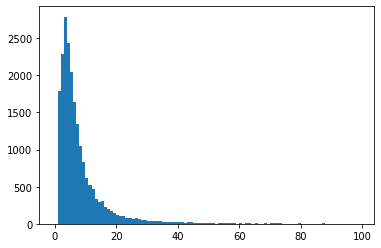

In [ ]:
len_distribution_array = np.array(len_distribution)

plt.hist(len_distribution_array, bins = np.arange(0,100,1))
plt.show()

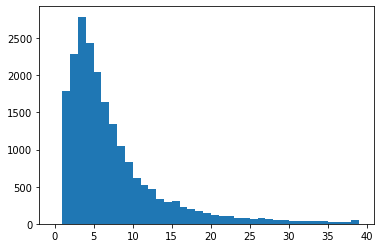

In [ ]:
plt.hist(len_distribution_array, bins = np.arange(0,40,1))
plt.show()

In [ ]:
sentence_len = 15

In [ ]:
for i in tqdm(range(len(embedding_model.wv.vectors))):
    embedding_matrix[i+1] = embedding_model.wv.vectors[i]

100%|██████████| 283367/283367 [00:00<00:00, 862283.31it/s]


In [ ]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
embedding_matrix[1] # = embedding_model.wv.get_vector('ㅈㅣㄴㅉㅏ_')

array([-0.35807574,  0.24967086, -0.39211652,  0.22270921, -0.30095124,
       -0.26930484, -0.03055471,  0.41335186, -0.10280499,  1.04495716,
        0.38705868,  0.25030985,  0.53404438, -0.11750946, -0.08750965,
        0.60228211, -0.71285009,  0.28803402,  0.62504017, -0.72744119,
       -0.38887247, -0.82178622,  0.23845713,  0.21378914, -0.11827174,
        0.56078953, -0.0617753 ,  0.48724902, -0.79592478, -1.35844982,
        0.05636201,  0.11509445,  0.2918855 ,  0.14894316, -1.5500443 ,
        0.80187112,  0.74725366,  0.66799784,  0.0449916 ,  1.63526201,
        0.19985682, -0.44706652,  0.01261949, -0.24851829,  0.59905064,
        1.25523901, -0.36310238,  0.61766183, -1.02303135,  0.11231538,
        0.19976164, -0.62349337, -0.20289727,  0.4597294 ,  0.72283882,
        0.2155575 , -0.50266254, -0.46275043, -0.02873549,  0.60092735,
        0.9514901 , -0.03955876, -0.46764556,  0.25555587,  0.62848908,
       -0.3047173 , -0.29829472, -0.07919572, -0.28102809, -0.86

In [ ]:
# X_train = X_train.apply(lambda row : jamo_sentence(str(row['comment'])).strip().split(" "), axis=1)

word_seq_train = X_train.apply(lambda row : sen_to_seq(row))
word_seq_test = X_test.apply(lambda row : sen_to_seq(row))

word_seq_train.head(5)

7959                 [0, 0, 1259, 78093]
2712                          [0, 20889]
13606                             [0, 0]
18062                           [147868]
113      [464, 28559, 65920, 53799, 464]
dtype: object

In [ ]:
word_seq_train = word_seq_train.apply(lambda row : seq_padding(row, sentence_len))
word_seq_test = word_seq_test.apply(lambda row : seq_padding(row, sentence_len))

word_seq_train.head(5)

7959     [0, 0, 1259, 78093, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2712     [0, 20889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
13606        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
18062    [147868, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
113      [464, 28559, 65920, 53799, 464, 0, 0, 0, 0, 0,...
dtype: object

In [ ]:
word_seq_train = np.array(word_seq_train.to_list())
word_seq_test = np.array(word_seq_test.to_list())

word_seq_train

array([[     0,      0,   1259, ...,      0,      0,      0],
       [     0,  20889,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       ...,
       [   115,   8278,   3291, ...,      0,      0,      0],
       [ 11473,  66961,    572, ...,      0,      0,      0],
       [  1583, 137346,      2, ...,      0,      0,      0]])

#### modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# from keras.utils import plot_model

In [ ]:
# set target data
y_train_catg = to_categorical(y_train, num_classes=7)
y_test_catg = to_categorical(y_test, num_classes=7)

y_train_catg

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

##### LSTM model

In [ ]:
lstm_model = Sequential()

e = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=sentence_len, trainable=False) # input_length = sentence_len
lstm_model.add(e)
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(32, return_sequences=False))
# lstm_model.add(BatchNormalization())
lstm_model.add(Dense(16, activation = 'tanh'))
lstm_model.add(Dense(7, activation = 'softmax')) # 여기서 3은 최종 라벨 갯수

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 100)           28336800  
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 64)            42240     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 119       
Total params: 28,392,103
Trainable params: 55,303
Non-trainable params: 28,336,800
_________________________________________________________________


In [ ]:
checkpoint_path = '/content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             save_best_only=True,
                             monitor='val_acc',
                             verbose=1)


lstm_model.fit(word_seq_train, y_train_catg, 
               epochs=30, verbose=2, 
               validation_data=(word_seq_test, y_test_catg),
               callbacks=[checkpoint])

Epoch 1/30
657/657 - 6s - loss: 1.1734 - acc: 0.6206 - val_loss: 1.0569 - val_acc: 0.6540

Epoch 00001: val_acc improved from -inf to 0.65400, saving model to /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt/assets


Epoch 2/30
657/657 - 3s - loss: 1.0580 - acc: 0.6486 - val_loss: 1.0375 - val_acc: 0.6490

Epoch 00002: val_acc did not improve from 0.65400
Epoch 3/30
657/657 - 3s - loss: 1.0264 - acc: 0.6554 - val_loss: 1.0419 - val_acc: 0.6620

Epoch 00003: val_acc improved from 0.65400 to 0.66200, saving model to /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo_7.ckpt/assets


Epoch 4/30
657/657 - 3s - loss: 0.9976 - acc: 0.6652 - val_loss: 1.0440 - val_acc: 0.6530

Epoch 00004: val_acc did not improve from 0.66200
Epoch 5/30
657/657 - 3s - loss: 0.9767 - acc: 0.6691 - val_loss: 1.0368 - val_acc: 0.6510

Epoch 00005: val_acc did not improve from 0.66200
Epoch 6/30
657/657 - 3s - loss: 0.9530 - acc: 0.6753 - val_loss: 1.0391 - val_acc: 0.6440

Epoch 00006: val_acc did not improve from 0.66200
Epoch 7/30
657/657 - 3s - loss: 0.9278 - acc: 0.6843 - val_loss: 1.0552 - val_acc: 0.6400

Epoch 00007: val_acc did not improve from 0.66200
Epoch 8/30
657/657 - 3s - loss: 0.9040 - acc: 0.6917 - val_loss: 1.0682 - val_acc: 0.6530

Epoch 00008: val_acc did not improve from 0.66200
Epoch 9/30
657/657 - 3s - loss: 0.8741 - acc: 0.7015 - val_loss: 1.0904 - val_acc: 0.6380

Epoch 00009: val_acc did not improve from 0.66200
Epoch 10/30
657/657 - 3s - loss: 0.8453 - acc: 0.7089 - val_loss: 1.1142 - val_acc: 0.6470

Epoch 00010: val_acc did not improve from 0.66200
Epoch 11/30


In [ ]:
# save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
saved_model_path = '/content/drive/Shareddrives/[GH x Sandbox]/code/DeepLevel/model/lstm_jamo7_model_h5'
lstm_model.save(saved_model_path, save_format='h5') #, options=save_options)

In [ ]:
config = lstm_model.get_config()
config

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'name': 'embedding_3_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 283368,
    'input_length': 15,
    'mask_zero': False,
    'name': 'embedding_3',
    'output_dim': 100,
    'trainable': False}},
  {'class_name': 'LSTM',
   'config': {'activation': 'tanh',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dropout': 0.0,
    'dtype': 'float32',
    'go_backwards': False,
    'implementation': 2,
    'kernel_cons

##### CNN model

In [ ]:
CNN_input = Input(shape = (sentence_len,))
Embedded = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=sentence_len, trainable=False)(CNN_input)
Permuted = Permute(dims = (2,1))(Embedded)
CONV1 = Conv1D(filters = 70, kernel_size= 3, padding = 'same')(Permuted)
CONV1 = ReLU()(CONV1)
Pooled1 = MaxPool1D(CONV1.shape[1])(CONV1)
Flattened1 = Flatten()(Pooled1)

CONV2 = Conv1D(filters = 70, kernel_size= 4, padding = 'same')(Permuted)
CONV2 = ReLU()(CONV2)
Pooled2 = MaxPool1D(CONV2.shape[1])(CONV2)
Flattened2 = Flatten()(Pooled2)

CONV3 = Conv1D(filters = 70, kernel_size= 5, padding = 'same')(Permuted)
CONV3 = ReLU()(CONV3)
Pooled3 = MaxPool1D(CONV3.shape[1])(CONV3)
Flattened3 = Flatten()(Pooled3)

Merged = Concatenate()([Flattened1, Flattened2, Flattened3])
CNN_output = Dense(3, activation='softmax')(Merged)

In [ ]:
CNN_model = Model(CNN_input, CNN_output)
CNN_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 100)      28336800    input_2[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 100, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 70)      3220        permute[0][0]                    
______________________________________________________________________________________________

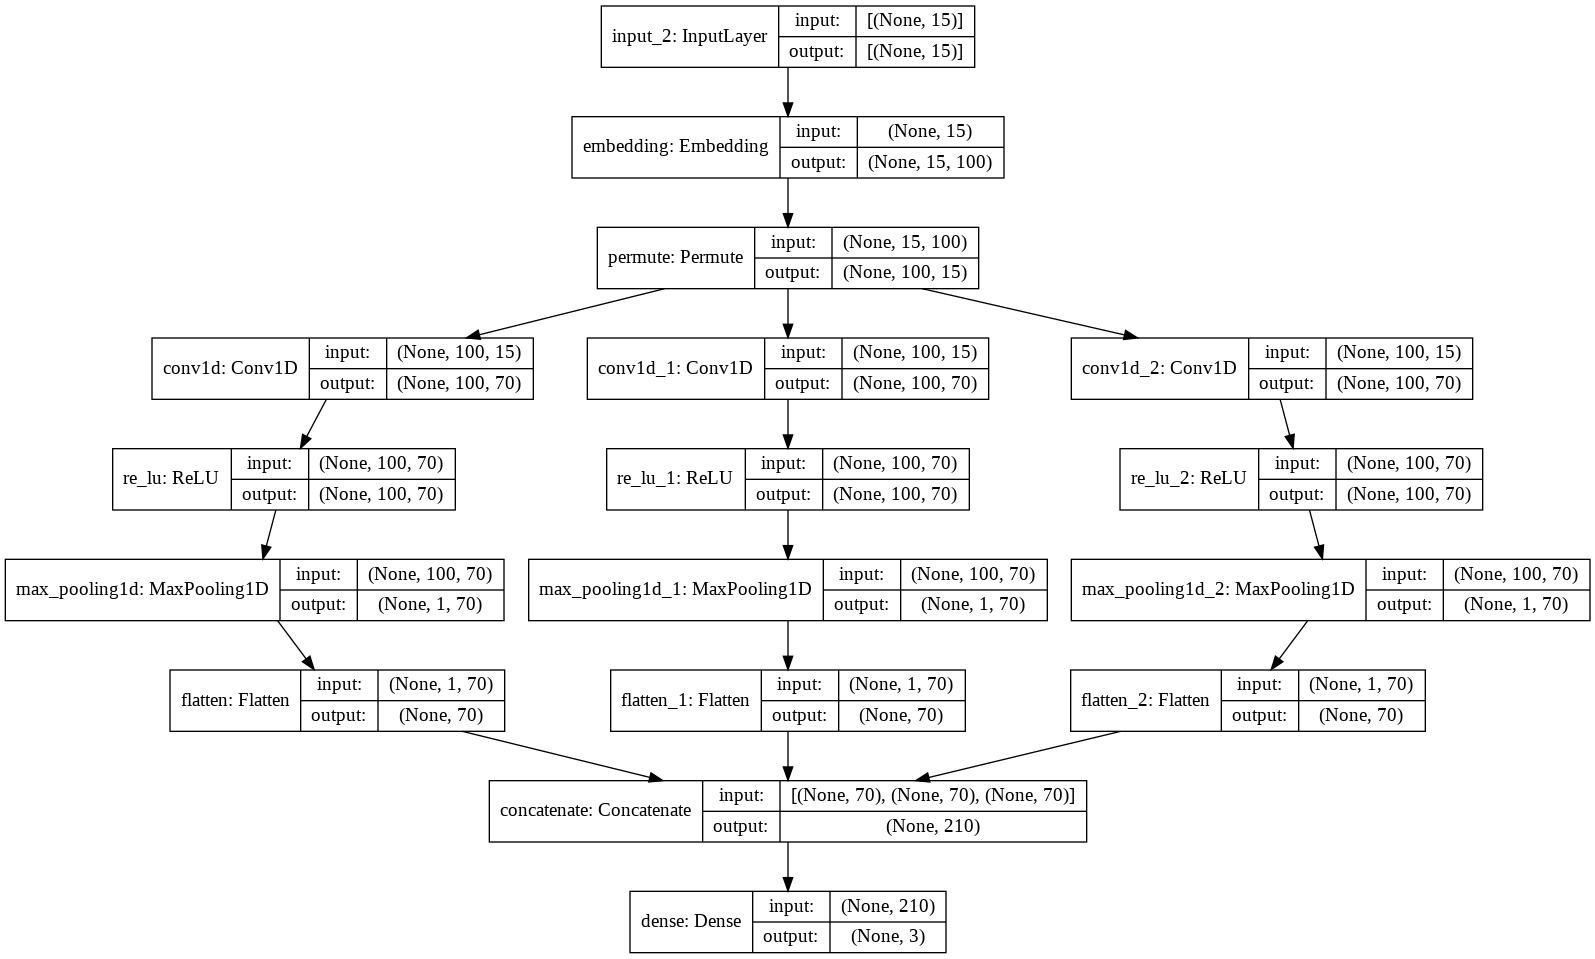

In [ ]:
plot_model(CNN_model, "cnn.png", show_shapes=True)

In [ ]:
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
CNN_model.fit(word_seq_train, y_train_catg, epochs=30, verbose=2, validation_data=(word_seq_test, y_test_catg))

Epoch 1/30
313/313 - 34s - loss: 0.9745 - acc: 0.5340
Epoch 2/30
313/313 - 1s - loss: 0.9086 - acc: 0.5806
Epoch 3/30
313/313 - 1s - loss: 0.8703 - acc: 0.6093
Epoch 4/30
313/313 - 1s - loss: 0.8329 - acc: 0.6418
Epoch 5/30
313/313 - 1s - loss: 0.8061 - acc: 0.6586
Epoch 6/30
313/313 - 1s - loss: 0.7761 - acc: 0.6766
Epoch 7/30
313/313 - 1s - loss: 0.7575 - acc: 0.6869
Epoch 8/30
313/313 - 1s - loss: 0.7296 - acc: 0.7066
Epoch 9/30
313/313 - 1s - loss: 0.7091 - acc: 0.7119
Epoch 10/30
313/313 - 1s - loss: 0.6878 - acc: 0.7228
Epoch 11/30
313/313 - 1s - loss: 0.6698 - acc: 0.7363
Epoch 12/30
313/313 - 1s - loss: 0.6474 - acc: 0.7471
Epoch 13/30
313/313 - 1s - loss: 0.6319 - acc: 0.7540
Epoch 14/30
313/313 - 1s - loss: 0.6167 - acc: 0.7605
Epoch 15/30
313/313 - 1s - loss: 0.6015 - acc: 0.7669
Epoch 16/30
313/313 - 1s - loss: 0.5861 - acc: 0.7763
Epoch 17/30
313/313 - 1s - loss: 0.5740 - acc: 0.7775
Epoch 18/30
313/313 - 1s - loss: 0.5601 - acc: 0.7835
Epoch 19/30
313/313 - 1s - loss: 0.5

# Model Load Test

In [ ]:
model = Sequential.from_config(config)

# e = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=sentence_len, trainable=False) # input_length = sentence_len
# model.add(e)
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(32, return_sequences=False))
# # lstm_model.add(BatchNormalization())
# model.add(Dense(16, activation = 'tanh'))
# model.add(Dense(7, activation = 'softmax')) # 여기서 3은 최종 라벨 갯수

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 100)           28336800  
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 64)            42240     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 119       
Total params: 28,392,103
Trainable params: 55,303
Non-trainable params: 28,336,800
_________________________________________________________________


In [ ]:
model.evaluate(word_seq_test,  y_test_catg, verbose=2)

32/32 - 1s - loss: 1.9419 - acc: 0.0520


[1.9419199228286743, 0.052000001072883606]

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model(saved_model_path, options=load_options)

In [ ]:
model.evaluate(word_seq_test,  y_test_catg, verbose=2)

32/32 - 13s - loss: 1.8720 - acc: 0.6170


[1.872029423713684, 0.6169999837875366]